In [0]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle, gzip, urllib.request, json

In [0]:
#To ensure reproducibility
random.seed(11)
np.random.seed(11)

In [3]:
# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    
train_images = train_set[0]
train_labels = train_set[1]

test_images = test_set[0]
test_labels = test_set[1]

# Check that we have the expected shape of arrays, should be (50000, 784), (50000,), (10000, 784), (10000,)
print(train_images.shape)
print(train_labels.shape)

print(test_images.shape)
print(test_labels.shape)

(50000, 784)
(50000,)
(10000, 784)
(10000,)


(28, 28)
5


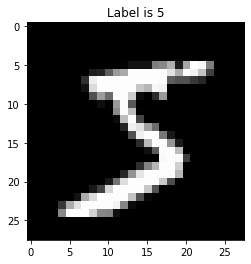

In [4]:
#Plot the first training image and label
train_sample1 = train_images[0,:]
train_sample1 = train_sample1.reshape((28, 28))
label = train_labels[0]
print(train_sample1.shape)
print(label)

plt.title('Label is {label}'.format(label=label))
plt.imshow(train_sample1, cmap='gray')
plt.show()

In [0]:
class boltzmann_machine(object):
    """
    Define a class for a boltzmann machine here.
    You must also define the functions below, but you can add additional arguments, etc.
    Also, note that you are welcome to write your own helper functions.
    Reminder: you should use numpy functions for vector and matrix operations. No autograd!
    """

    # The initialization function for the boltzmann machine
    def __init__(self, num_visible, num_hidden):
        self.num_hidden = num_hidden
        self.num_visible = num_visible
        self.debug_print = True
        np_rng = np.random.RandomState(1234)

        self.weightVH = np.random.normal(0, 0.01, size=(self.num_visible, self.num_hidden))
        self.weightHH = np.random.normal(0, 0.01, size=(self.num_hidden, self.num_hidden))
        self.weightHH = (self.weightHH + self.weightHH.T)/2
        np.fill_diagonal(self.weightHH, 0.0)# symmetric & diagonal=0
        self.bias = np.zeros(num_visible + num_hidden) #thresholds

        self.energy = np.zeros(num_visible + num_hidden)
        self.states = np.array([np.zeros(num_visible + num_hidden)])
        print('You have inititialized a BM!')

    # The function for Gibbs sampling
    def gibbs(self, sample_img):
        #I define two gibbs sampling, this is for wake phase
        num_visible = self.num_visible
        num_hidden = self.num_hidden
        coactivity = np.zeros((num_visible+num_hidden,num_visible+num_hidden))
        temperature = 201
        #awake phase
        #clamp visible states to one image
        self.states[0][:num_visible] = sample_img[:num_visible]
        #Assigning random values to the hidden units
        self.states[0][-num_hidden:] = np.random.choice([0,1],num_hidden)
        numUnitsToSelect = self.num_hidden
        num_runs = 100 # increase with Temp goes down
        count =0
        while (temperature >1):
            for i in range(num_runs):
                # randomly turn ON/OFF a hidden unit
                unit= num_hidden +num_visible -np.random.randint(1,num_hidden+1)
                self.energy[unit] = self.bias[unit]- np.dot(self.states[0][:num_visible], self.weightVH[:,unit-num_visible])-np.dot(self.states[0][-num_hidden:],self.weightHH[:,unit-num_visible])
                p = 1. / (1.+ np.exp(self.energy[unit] / temperature))
                self.states[0][unit] = 1 if  np.random.uniform() <= p else 0
                coactivity += np.dot(self.states.T ,self.states) #get the coactivity matrix
            num_runs += 10
            temperature -= 5
            count = count+num_runs
        return (coactivity/count)

    def gibbsSleep(self):
        num_visible = self.num_visible
        num_hidden = self.num_hidden
        coactivity = np.zeros((num_visible+num_hidden,num_visible+num_hidden))
        temperature = 201
        #Assigning random values to all visible & hidden units
        self.states[0][:] = np.random.choice([0,1],num_hidden+num_visible)
        num_runs = 100 # increase as Temp goes down
        count =0
        while (temperature >1):
            for i in range(num_runs):
                # randomly turn ON/OFF a visible or hidden unit ;
                unit = np.random.randint(num_hidden+num_visible)
                if (unit >=784):
                    self.energy[unit] = self.bias[unit]- np.dot(self.states[0][:num_visible], self.weightVH[:,unit-num_visible])-np.dot(self.states[0][-num_hidden:],self.weightHH[:,unit-num_visible])
                else:
                    self.energy[unit] = self.bias[unit]- np.dot(self.states[0][-num_hidden:], self.weightVH[unit,:])
                p = 1. / (1.+ np.exp(self.energy[unit] / temperature))
                self.states[0][unit] = 1 if  np.random.uniform() <= p else 0
                coactivity += np.dot(self.states.T ,self.states) #get the coactivity matrix
            num_runs += 10
            temperature -= 5
            count = count+num_runs
        return (coactivity/count)


    def update(self,pplus,pminus,learn,temp):
        #update weights of VH
        for i in range(self.num_visible):
            for j in range(self.num_hidden):
                self.weightVH[i][j] = self.weightVH[i][j]+ learn * (1.0 / temp) * (pplus[i][self.num_visible+j] - pminus[i][self.num_visible+j])
        #update weights of HH
        for k in range(self.num_hidden):
            for m in range(k+1,self.num_hidden):
                self.weightHH[k][m] = self.weightHH[k][m]+ learn * (1.0 / temp) * (pplus[self.num_visible+k][self.num_visible+m] -pplus[self.num_visible+k][self.num_visible+m])

        #update thresholds-bias: <a_i>+ = pplus[i][i]
        for i in range (self.num_visible+self.num_hidden):
            self.bias[i] = self.bias[i]+(1.0 / temp) *(pminus[i][i] - pplus[i][i])


    #calculate the probability of each visible unit being on given hidden units p(v=1|h)
    def decode(self,temp):
        probs=[]
        for unit in range(self.num_visible):
            self.energy[unit] = self.bias[unit]- np.dot(self.states[0][-self.num_hidden:], self.weightVH[unit,:])
            p = 1. / (1.+ np.exp(self.energy[unit] / temp)) 
            probs += [p]
        return probs
        
    # The function for training the boltzmann machine
    def train(self,train_images):
        max_epochs = 100
        learning_rate = 0.01
        temperature = 1
        #p_minus = self.gibbsSleep()
        for epoch in range(max_epochs):
            loss=0
            for i in range(len(train_images)):
                p_minus = self.gibbsSleep()
                minus_prob = self.decode(temperature)
                p_plus = self.gibbs(train_images[i])
                self.update(p_plus,p_minus,learning_rate,temperature)
                #calculte loss by getting a mean field approximation of the -log(p(v^k)^-) for each image
                for i in range(self.num_visible):
                    if (self.states[0][i] == 1):
                        loss += -np.log(minus_prob[i])
                    else:
                        loss += 1-np.log(minus_prob[i])
            if self.debug_print:
                print("Epoch %s: loss value is %s" % (epoch, loss))


    # The function for testing the boltzmann machine
    def test(self,test_images):
        temperature = 1
        p_minus = self.gibbsSleep()
        minus_prob = self.decode(temperature)
        loss=0
        for i in range(len(test_images)):
            p_plus = self.gibbs(test_images[i])
            #calculate loss
            for i in range(self.num_visible):
                if (self.states[0][i] == 1):
                    loss += -np.log(minus_prob[i])
                else:
                    loss += 1-np.log(minus_prob[i])
        print('The total loss value of testing set is {}'.format(loss))

    # The function for testing the boltzmann machine
    def test(self,hidden):
      #given a hidden units input, decode.
      for unit in range(self.num_visible):
         self.energy[unit] = self.bias[unit]- np.dot(hidden, self.weightVH[unit,:])
         p = 1. / (1.+ np.exp(self.energy[unit] / temp)) 
         self.states[0][unit] = 1 if  np.random.uniform() <= p else 0
      return self.states[:self.num_visible]
        



In [0]:
def binary_image(image):
    for i in range(len(image)):
        if image[i]<0.5:
            image[i]=0
        else:
            image[i]=1
    return image

In [8]:
# Create a Boltzmann machine and train it on one img, BUT my loss does decrease, but keep increasing?????
train_images[1] = binary_image(train_images[1])
bm = boltzmann_machine(num_visible = 784, num_hidden = 20)
bm.train(train_images[:1])

You have inititialized a BM!
Epoch 0: loss value is 1327.8308022912656
Epoch 1: loss value is 1502.6398217103522
Epoch 2: loss value is 1724.0517918927287
Epoch 3: loss value is 1974.7356288587746
Epoch 4: loss value is 2271.0432061776974


KeyboardInterrupt: ignored

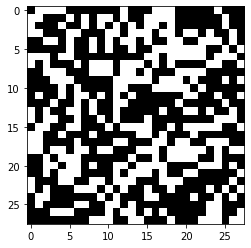

In [9]:
# Plot generated images from your Boltzmann machine running freely (no clamping)
bm.gibbsSleep()
out = bm.states[0][:784].reshape((28, 28))
plt.imshow(out, cmap='gray')
plt.show()